# Menchero, J., 2010. "Characteristics of Factor Portfolios" 

#TODO Write brief introduction
### References:

Menchero, J., 2010. "Characteristics of Factor Portfolios," *Journal of Performance Measurement* **15**(1) (Fall), 52-62.

Menchero, J., and Lee, J., 2015. "Efficiently Combining Multiple Sources of Alpha," *Journal of Investment Management* **14**(4), 71-86.

Ruud, P., *An Introduction to Classical Economic Theory*, (New York: Oxford University Press, 2000)

Heston, S.L., and Rowenhorst, K.G., 1994. "Does Industrial Structure Explain the Benefits of Interenation Diverificiation?" *Journal of Financial Economics* **36**, 3-27.

---

## Import external libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

---

## Read in factor universe data

For simplicity the S&P 500 is used as our universe in this example which avoids any country differences.

#### Details of each column are given below
>    *Company Symbol* 

>    *Company Name - (Not used)*

>    *GIC Sector* *(Typically this would be at industry level but the Sector is used for illustrative purposes)*

>    *1 day forward return (Ret)*

>    *Divident Yield (Forward) - (Not used)*

>    *PE Ratio (Forward) - (Not used)*

>    *Price to Book value (Trailing Twelve Months)*

>    *Market Cap (millions)*

>    *Beta to S&P 500 (3Y)*

>    *Return on Equity (Trailing Twelve Months) - (Not used)*

In [2]:
df = pd.read_csv('data.csv', index_col='Symbol')
df['Ret'] = df['Ret'].replace('unch', 0).astype(float)
df = df.fillna(df.mean()).dropna()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 499 entries, A to ZTS
Data columns (total 9 columns):
Name                        499 non-null object
GICS Sector                 499 non-null object
Ret                         499 non-null float64
Dividend Yield (Forward)    499 non-null float64
PE Ratio (Forward)          499 non-null float64
Price to Book Value         499 non-null float64
Market Cap (millions)       499 non-null float64
Beta (3Y)                   499 non-null float64
Return on Equity (TTM)      499 non-null float64
dtypes: float64(7), object(2)
memory usage: 39.0+ KB


---

## Transform the original data into a dataframe containing sector and style factors

Please note, the metrics used to determine the exposure to each style factor are intentionally basic. In practice, style factor exposures are measured using a blend of multiple metrics. Determining the metrics used to measure this exposure and and the weighting scheme to apply plays a significant role in factor based investing.

#### The factors included are as follows:
> world_factor = All stocks have a unit exposure to the world factor which caputes the overall effect of the equity market.

> sector = The stock is assigned an exposure of 0 or 1, depending on whether it belongs to the sector under consideration.

> value = $ \frac{1}{PricetoBookValue} $

> size = $ \ln{(MarketCap(millions))} $

> low_risk = $ \beta _{SPX} $

In [4]:
df_styles = pd.DataFrame(np.ones(len(df)), columns=['world_factor'], index=df.index)
dummy_var = pd.get_dummies(df['GICS Sector'], prefix='Sector')
df_styles = pd.concat([df_styles, dummy_var], axis=1)

In [5]:
df_styles['value'] = 1 / df['Price to Book Value']
df_styles['size'] = np.log(df['Market Cap (millions)'])
df_styles['low_risk'] = df['Beta (3Y)']

In [6]:
df_styles.head()

,world_factor,Sector_Consumer Discretionary,Sector_Consumer Staples,Sector_Energy,Sector_Financials,Sector_Health Care,Sector_Industrials,Sector_Information Technology,Sector_Materials,Sector_Real Estate,Sector_Telecommunication Services,Sector_Utilities,value,size,low_risk
Symbol,,,,,,,,,,,,,,,
A,1.0,0,0,0,0,1,0,0,0,0,0,0,0.226978,9.919526,1.4876
AAL,1.0,0,0,0,0,0,1,0,0,0,0,0,0.045881,9.937293,1.3200
AAP,1.0,1,0,0,0,0,0,0,0,0,0,0,0.368602,9.171792,0.9451
AAPL,1.0,0,0,0,0,0,0,1,0,0,0,0,0.133536,13.764370,1.1667
ABBV,1.0,0,0,0,0,1,0,0,0,0,0,0,0.022639,11.963634,1.6320


---

## Simple Factor Portfolios

**From Menchero (2010):** 
Factor returns are typically estimatd by cross-sectional regression. In this framework, each factor can be represented by a portfolio for which the return exactly replicates the payoff to the factor. There are two ways of constructing factor-mimicking portfolios. Simple factor portfolios typically result from univariate regressions that effectively treat the factor in isolation.

While the aim of this post is to focus on pure factor portfolio which result from multivariate regressions that consider all factors simulataneously, simple factor portfolios remain important. Their holdings are clear and intuitive, and they serve as the foundation for understanding pure factors.

To derive the simple factor portfolios for styles, we perfrom  univariate cross-sectional regression including an intercept term,



\begin{equation*}
r_n = f_W^S + X_{ns}f_s^S + u_n^S,
\quad (1)
\end{equation*}

Where $r_n$ is local excess return (we assume a zero risk free rate throughout) of stock $n$, $f_W^S$ is the intercept term, $f_s^S$ is the return of the style factor $s$, $X_ns$ is the stock exposure to the style factor, and $u_n^S$ is the specific return of the stock. Every stock has an exposure of 1 to the intercept term, which we identify as the World factor.

In order to reduce estimation error in the factor returns, regression weights are used so that "noisy" stocks (i.e., those with high specific risk) are down-weighted. In practice, regression weights $v_n$ are often taken as proportional to the square root of the market capitalization, although other weighting schemes are possible. 

\begin{equation*}
v_n = \frac{\sqrt(Market Cap (millions)_n)} {\sum_n\sqrt(Market Cap (millions)_n)}
\quad (2)
\end{equation*}

This results in standardize regression weight that sum to 1 over the estimation universe.

\begin{equation*}
\sum_nv_n = 1
\quad (3)
\end{equation*}

**Example:** The regression weights are calculated as follows:

In [7]:
v_n = df['Market Cap (millions)'] ** 0.5 / (df['Market Cap (millions)'] ** 0.5).sum()

We have the freedown to define the mean and standard deviation of the style exposures without alterning the regression fit. For present purposes, we standardize style factor exposures to be regression-weighted mean zero,

\begin{equation*}
\sum_nv_nX_{ns} = 0
\quad (4)
\end{equation*}

This implies no collinearity between the World factor. We also set the regression-weighted standard deviation of the style factor to 1,

\begin{equation*}
\sum_nv_nX_{ns}^2 = 1
\quad (5)
\end{equation*}

**Example:** The implementation to achieve the desired regression-weighted mean and standard deviation is as follows:

In [8]:
style_names = ['value', 'size', 'low_risk']
df_simple = df_styles.copy()

simple_means = np.dot(df_styles[style_names].T, v_n)
simple_stds = np.dot(((df_styles[style_names] - simple_means)**2).T, v_n) ** 0.5

df_simple[style_names] = (df_styles[style_names] - simple_means) / simple_stds

**Example:** We can verify we now have a regression-weight mean of 0 and standard deviation of 1.

In [9]:
for style in style_names:
    print('style: {}\nsimple mean: {}\nsimple std: {}\n'.format(
            style,
            round(np.dot(df_simple[style].T, v_n), 4),
            round(np.dot(((df_simple[style] - np.dot(df_simple[style].T, v_n))**2).T, v_n) ** 0.5, 4)
            )
          )

style: value
simple mean: 0.0
simple std: 1.0

style: size
simple mean: 0.0
simple std: 1.0

style: low_risk
simple mean: 0.0
simple std: 1.0



With this standardization convention, the simple style factor return is given by

\begin{equation*}
f_s^S = \sum_n(v_nX_{ns})r_n
\quad (6)
\end{equation*}

which represents the return of a portfolio with weights $v_nX_{ns}$. In other words, the simple style factor portfolio goes long stocks with positive exposure, and short stocks with negative exposure, while taking proportionately larger positions in stocks with greater regression weight. 

The portfolio is also strickly dollar neutal, since the weights sum to zero by virtue of the regression-weighted standardisation (i.e. regression-weighted mean 0) shown above. The portfolio exposure to the factor, given by the sum product of the stock weight $v_nX_{ns}$ and the stock exposure $X_{ns} is equal to 1 thanks again to the regression-weighted standardisation (i.e. regression-weighted standard deviation 1).

**Example:** We can demonstrate this by using value, size, and low risk as an example. The 1 day simple factor returns are calculated below:

In [10]:
style_names = ['value', 'size', 'low_risk']

X_s_simple = df_simple[style_names]
r_n = df['Ret']

f_s_simple = np.dot(np.dot(X_s_simple.T, np.diag(v_n.values)), r_n)

for (style, f) in zip(style_names, f_s_simple):
    print('{}: {}%'.format(style, round(f*100, 3)))

value: -0.067%
size: -0.061%
low_risk: -0.05%


The return of the simple World factor is given by

\begin{equation*}
f_w^S = \sum_nv_nr_n
\quad (7)
\end{equation*}

**Example:** Which is

In [11]:
print('world_factor: {}%'.format(round(np.dot(v_n.T, r_n)*100, 3)))

world_factor: -0.751%


**Quantile construction alternative:** An alternative and perhaps more commonly used approach to constructing simple factor portfolios is to go long the top quintile (equally weighted) and go short the bottom quintile (equally weighted). This portfolio construction scheme is also of the form given by Equation 5. However, rather than using a regression weight propotional to the square root of market capitalization, the middle three quintiles receive zero regression weight, whereas the regression weights are inversely proportional to the factor exposure for the top and bottom quintiles.

---

## Pure Factor Portfolios

**From Menchero (2010):** As aluded to previously, pure factor portfolios are formed by multivariate regression. Within this example, the factor structure consists of a World factor, 11 sector factors (based on the GICS sector classification), and 3 style factors. 

\begin{equation*}
r_n = f_w^P + \sum_iX_{ni}f_i^P + \sum_sX_{ns}f_s^P+u_n^P
\quad (8)
\end{equation*}

*I should highlight at this point that I have excluded a country factor as it is not needed for my estimation universe but typically it would also be including within the model.*

with the superscipt $P$ used to denote the *pure* factor. As before, the model uses regression weights proportional to the square root of market capitalization, and an estimation universe based on the S&P 500 (SPX). Each stock has a unit exposure to the World factor, and unit exposure to the particular sector to which it belongs. The style factors are mean zero and standard deviation 1, in the manner decribed below. The specific returns $u_n^P$ are assumed to be mutually uncorrelated and also uncorrelated with the factor returns

Since every stock belong to a sector, the factor structure above constains one exact collinearity. In order to obtain a unique regression solution, we impose one constraint: the cap-weighted sector factor returns sum to zero. This constraint effectly calibrates the model so that sector factors collectively contribute zero to the return of the cap-weighted world portfolio.

When introducing simple factor portfolios, it proved useful to standardize the style factors to be regression-weighted mean zero. This made the style factors othogonal (i.e., no collinearity) to the World Factor, which in turn facilitated interpretation of the style factor return, as in Equation 6. Although such standardisation is certainly still possible in the multivariate case, the motivation is lost, since collinearity among style factors precludes simple analytic solutions as in Equation 6. Instead, we adopt the convention that the style exposures are *cap-weighted* mean zero,

\begin{equation*}
\sum_nw_nX_{nx} = 0
\quad (9)
\end{equation*}

for all styles $s$. This calibrates the model so that the cap-weighted world portfolio is *style neutral*.

**Example:** The implementation to achieve the desired cap-weighted mean and standard deviation is as follows:

In [12]:
w_n = df['Market Cap (millions)'] / df['Market Cap (millions)'].sum()

In [13]:
df_pure = df_styles.copy()

pure_means = np.dot(df_styles[style_names].T, w_n)
pure_stds = np.dot(((df_styles[style_names] - pure_means)**2).T, w_n) ** 0.5

df_pure[style_names] = (df_styles[style_names] - pure_means) / pure_stds

**Example:** We can verify we now have a cap-weight mean of 0 and standard deviation of 1.

In [14]:
for style in style_names:
    print('style: {}\npure mean: {}\npure std: {}\n'.format(
            style,
            round(np.dot(df_pure[style].T, w_n), 4),
            round(np.dot(((df_pure[style] - np.dot(df_pure[style].T, w_n))**2).T, w_n) ** 0.5, 4)
            )
          )

style: value
pure mean: -0.0
pure std: 1.0

style: size
pure mean: -0.0
pure std: 1.0

style: low_risk
pure mean: -0.0
pure std: 1.0



**From Menchero (2010) and Menchero and Lee (2015):** Factor returns are estimated using weighted and restricted least-squares regression. The general solution, as described by Ruud (2000), can be written as

\begin{equation*}
\Omega^P = R'(R'X'WXR)^{-1}R'X'W
\quad (10)
\end{equation*}

\begin{equation*}
f_k^P = \Omega_{nk}^Pr_n
\quad (11)
\end{equation*}

where $R$ represents the restriction matrix which constrains the cap-weighted sector returns to equal zero, $X$ is stock factor exposures, $W$ is the regression weighting matrix whos diagonal elements are given by $w_n$ and whose off-diagonal elements are zero.

Most importantly, $\Omega^P$ represents the weight of stock $n$ in pure factor portfolio $k$ and $f_k^P$ is the pure factor returns. The full insight of factor modeling can only be attained when pure factor portfolios are clearly interpreted.

#### Expanded explanation of $R$ (the Restriction Matrix)

**TCRAWF88 modification of Ruud (2010):** For me personally, understanding how to set up $R$ was initially quite challenging so I wanted to give some further details around how it can be done. 

Pages 77-84 of Ruud (2000) has some particularly useful examples so I use an adjusted version of their example below.

Consider the single linear restriction

\begin{equation*}
\beta_3 + \beta_4 + \beta_5 = 0
\quad (12)
\end{equation*}

The constraint can expressed in matrix form as

\begin{equation*}
\beta = Rg
\quad (13)
\end{equation*}

Where R is *5 x (5 - 1)* constrain matrix, and $g$ is a *(K - 1) x 1* vector of auxiliary factor returns. One restriction reduces 5 coefficients to 4 unrestricted ones (i.e., if we had $n$ restrictions then we would have 4 - $n$ unrestricted ones).

\begin{equation*}
\beta =  
\begin{vmatrix}
\beta_1 \\
\beta_2 \\
\beta_4 \\
\beta_4 \\
\beta_5 \\
\end{vmatrix} =
\begin{vmatrix}
1 & 0 & 0 & 0 \\
1 & 1 & 0 & 0 \\
1 & 0 & -1 & -1 \\
1 & 0 & 1 & 0 \\
1 & 0 & 0 & 1 \\
\end{vmatrix}
\begin{vmatrix}
\beta_1 \\
\beta_2 \\
\beta_4 \\
\beta_5 \\
\end{vmatrix}
\quad (14)
\end{equation*}

We can then verify that with our constraint will always be satified for any $g$ due to the set up of $R$ as $\beta_3$ will always offset $\beta_4 + \beta_5$. In the case where a weighting scheme $W_5$ was applied to $\beta$, the above example would become

\begin{equation*}
\beta =  
\begin{vmatrix}
\beta_1 \\
\beta_2 \\
\beta_4 \\
\beta_4 \\
\beta_5 \\
\end{vmatrix} =
\begin{vmatrix}
1 & 0 & 0 & 0 \\
1 & 1 & 0 & 0 \\
1 & 0 & -\frac{W_4}{W_3} & -\frac{W_5}{W_3} \\
1 & 0 & 1 & 0 \\
1 & 0 & 0 & 1 \\
\end{vmatrix}
\begin{vmatrix}
\beta_1 \\
\beta_2 \\
\beta_4 \\
\beta_5 \\
\end{vmatrix}
\quad (15)
\end{equation*}

This ensures the combined weight of the restriction always offsets the weight those that are unrestricted.

Our cap-weighted group factor returns constraint can be stated as 

\begin{equation*}
\sum_gSW_gf_g^S = 0
\quad (16)
\end{equation*}

where $SW_g$ is the capitilisation weight of group $g$.

**Example:** To obtain $SW_g$ we need to get the cap-weights of each sector:

In [15]:
sector_names = [x for x in df_pure.columns if 'Sector' in x]
SW_g = pd.DataFrame(np.zeros(len(df_pure.columns)), index=df_pure.columns, columns=['Wgt'])
sw_g = [df['Market Cap (millions)'][df['GICS Sector'] == x.replace('Sector_', '')].sum() / df['Market Cap (millions)'].sum() for x in sector_names]
SW_g.loc[sector_names] = pd.DataFrame(sw_g, index=sector_names)

**Example:** We now need to set up $R$. Here we must chose a Sector to restrict. For no reason other than it is the first sector that appears in our list, we chose Consumer Discretionary. The setup is outlined below:

In [16]:
R_name = 'Sector_Consumer Discretionary'
R_loc = SW_g.index.get_loc(R_name)
R_w = SW_g.loc[R_name]
R_v = -SW_g.drop(R_name, axis=0) / R_w

In [17]:
R = pd.DataFrame(np.identity(len(df_pure.columns))).iloc[:, :-1]
R.iloc[R_loc, :] = R_v.values.T
temp_diag = pd.DataFrame(np.identity(len(df_pure.columns)-(R_loc+1)))
R.iloc[R_loc+1:, R_loc:] = temp_diag.values

In [18]:
round(R, 2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1.0,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0
1,-0.0,-0.58,-0.46,-1.1,-1.01,-0.73,-2.34,-0.2,-0.2,-0.13,-0.2,-0.0,-0.0,-0.0
2,0.0,1.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0
3,0.0,0.00,1.00,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0
4,0.0,0.00,0.00,1.0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0
5,0.0,0.00,0.00,0.0,1.00,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0
6,0.0,0.00,0.00,0.0,0.00,1.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0
7,0.0,0.00,0.00,0.0,0.00,0.00,1.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0
8,0.0,0.00,0.00,0.0,0.00,0.00,0.00,1.0,0.0,0.00,0.0,0.0,0.0,0.0
9,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.0,1.0,0.00,0.0,0.0,0.0,0.0


**Example:** Set up the variables to match the notation in Equation 10 and 11:

\begin{equation*}
\Omega^P = R'(R'X'WXR)^{-1}R'X'W
\end{equation*}

\begin{equation*}
f_k^P = \Omega_{nk}^Pr_n
\end{equation*}

In [19]:
R = R
X = df_pure
W = pd.DataFrame(np.diag(v_n.values), index=v_n.index, columns=v_n.index)
r = df['Ret']

In [20]:
omega_p = np.dot(np.dot(R, np.linalg.inv(
        np.dot(np.dot(R.T, X.T), np.dot(W, np.dot(X, R))))), np.dot(np.dot(R.T, X.T), W))
f_pure = np.dot(omega_p, r)

omega_p = pd.DataFrame(omega_p, index=X.columns, columns=X.index)
f_pure = pd.DataFrame(f_pure, index=X.columns, columns=['f_pure'])

**Pure Factor Portfolio weights are as follows:**

In [21]:
omega_p

Symbol,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
world_factor,0.000643,0.000700,0.000165,0.028629,0.006504,0.000529,0.000445,0.004859,0.005388,0.006073,...,0.000348,0.000781,0.012598,0.000049,0.000086,0.000239,0.001201,0.000829,0.000160,0.001697
Sector_Consumer Discretionary,-0.002065,-0.001855,0.006199,-0.008258,-0.003683,-0.002083,-0.002161,-0.002479,-0.005667,-0.005909,...,-0.001686,-0.003134,-0.000710,-0.001111,-0.001647,-0.001404,0.010418,-0.001533,-0.001717,-0.002758
Sector_Consumer Staples,0.000664,-0.000116,-0.001100,-0.016950,0.002651,-0.000866,-0.006404,0.003731,-0.006516,-0.010523,...,-0.005166,-0.004082,-0.012852,-0.000073,-0.000546,-0.002202,-0.005191,-0.000595,0.000050,-0.002812
Sector_Energy,-0.001881,-0.000645,-0.001256,-0.013603,-0.002582,-0.001175,0.000853,-0.005305,-0.004230,-0.003380,...,-0.000406,-0.001625,0.096461,-0.002610,-0.003211,-0.000510,0.000492,-0.003035,-0.001491,-0.000500
Sector_Financials,-0.001351,0.000546,-0.001413,-0.015377,0.000717,-0.000474,0.001826,-0.005435,-0.003321,-0.002449,...,0.008450,-0.001193,-0.008643,-0.003851,-0.004612,-0.000259,0.001687,-0.004217,0.006668,0.001115
Sector_Health Care,0.009502,-0.001683,-0.000956,-0.014227,0.026146,0.009080,0.009052,0.022838,-0.005651,-0.005902,...,-0.001117,-0.002401,-0.003636,0.007083,-0.001033,-0.001034,-0.001896,0.010778,-0.001315,0.013412
Sector_Industrials,-0.002308,0.010639,-0.001343,-0.007048,-0.004535,-0.002317,-0.002277,-0.002593,-0.005844,-0.005954,...,-0.001566,-0.003258,0.000826,-0.000903,-0.001420,0.008676,-0.002364,-0.001325,-0.001876,-0.003135
Sector_Information Technology,-0.001455,-0.001892,-0.000055,0.028113,-0.010152,-0.001243,-0.000535,-0.005754,0.012326,0.013579,...,0.000357,0.006550,-0.007959,0.000799,0.005574,-0.000293,-0.001671,-0.000019,-0.000620,-0.002952
Sector_Materials,-0.003663,-0.002535,-0.001697,-0.001218,-0.005723,-0.002710,0.000608,-0.005986,-0.004796,-0.002698,...,0.000168,-0.002669,0.006478,-0.002409,-0.003115,-0.000961,0.000036,-0.002699,-0.002860,-0.002159
Sector_Real Estate,-0.001641,-0.001246,-0.002227,0.002421,0.003253,-0.002308,-0.004704,0.001944,-0.005685,-0.007204,...,-0.004326,-0.005072,0.000763,-0.002240,-0.003229,-0.002484,-0.003488,-0.002396,-0.001969,-0.002591


**Pure Factor Returns are as follows:**

In [22]:
f_pure

,f_pure
world_factor,-0.007955
Sector_Consumer Discretionary,-0.000906
Sector_Consumer Staples,-0.005999
Sector_Energy,0.007836
Sector_Financials,0.001040
Sector_Health Care,0.000897
Sector_Industrials,-0.001024
Sector_Information Technology,0.000715
Sector_Materials,-0.004019
Sector_Real Estate,-0.008636


**From Menchero (2010):** The pure World is closely related to the cap-weighted world portfolio. As noted. the constraints on the cap-weighted sector factor returns imply that sectors do not contribute to the world portfolio. Styles also do not contribute, due to the standardisation convention that the world portfolio be style neutral. Therefore, the return of the world portfolio, $F_w$, can be attributed using Equation 8,

\begin{equation*}
F_w = f_w^P + \sum_nw_nu_n^P
\quad (17)
\end{equation*}

where $w_n$ is the weight of stock $n$ in the world portfolio (i.e., the estimation universe). The specific constribution to the world portfolio return is extremely small, since specific returns diversify away. Equation 17 therefore implies that the pure World factor $f_w^P$ essentially represents the cap-weighted portfolio.

**Example:** We can verify this as follows:

In [28]:
f_w = f_pure.loc['world_factor'][0]
u_n = np.dot(X, f_pure) - np.matrix(r).T
wu_n = np.array(np.dot(w_n, u_n))[0][0]
F_w = f_w + wu_n

In [29]:
print('world_portfolio: {}%\nworld_factor: {}%\nspecific_contribution: {}%'.format(
    round(F_w*100,3), 
    round(f_w*100, 3), 
    round(wu_n*100, 3)
))

world_portfolio: -0.774%
world_factor: -0.796%
specific_contribution: 0.021%


---

## Measuring Collinearity Effects

**From Menchero (2010):** The concepts of simple and pure factor portfolios provid an intuitive framework for understanding and measuring the effect of collinearity in global equity factor models. Simple factor portfolios, by construction, have no collinearity. The effects of collinearity in a factor model can be understood, therefore, by comparing pure factor portfolios to their simple counterparts.

One simple and intuitive measure of collinearity is the *Factor Weight Correlation*, defined as the cross-sectional correlation between the weights of the simple and pure factor portfolios. Let $\Omega_{nk}^P$ denote the weight in the simple factor portfolio. The Factor Weight Correlation is given by

\begin{equation*}
\rho_k^{CS} = \frac{\sum_n\Omega_{nk}^P\cdot\Omega_{nk}^S}{\sigma(\Omega_k^P)\sigma(\Omega_k^P)}
\quad (18)
\end{equation*}

Note that since the pure and simple factor portfolios are strictly dollar neutral (i.e., zero exposure to the World factor), their weights are mean zero. The correlation in Equation 18 quantifies the "similarity" in weights between simple and pure factor portfolios.

**Example:** We can calculate this as

In [148]:
# TODO calculate Factor Weight Correlation

In the chart below, we present the Factor Weight Correlation all factors included in this example analysis.

In [147]:
# TODO Factor Weight Correlation Chart

Another useful measure of collinearity is the *Factor Leverage Ratio*, defined as the ratio of leverage of the pure and simple factor portfolios,

\begin{equation*}
L_k = \frac{\sum_n\lvert\Omega_{nk}^P\lvert}{\lvert\Omega_{nk}^P\lvert}
\quad (19)
\end{equation*}

Intuitively, we expect the Factor Leverage Ratio to be greater than 1, since the pure factor portfolio must assume additional long/short positions to hedge out exposure to the other factors.

**Example:** We calculate the Leverage Ratios of our examples below:

In [132]:
factor_lev_ratio = omega_p.loc[style_names].abs().sum(axis=1) / omega_s.loc[style_names].abs().sum(axis=1)

Below, we show a histogram of Factor Leverage Ratios for the three style factors included in this example analysis

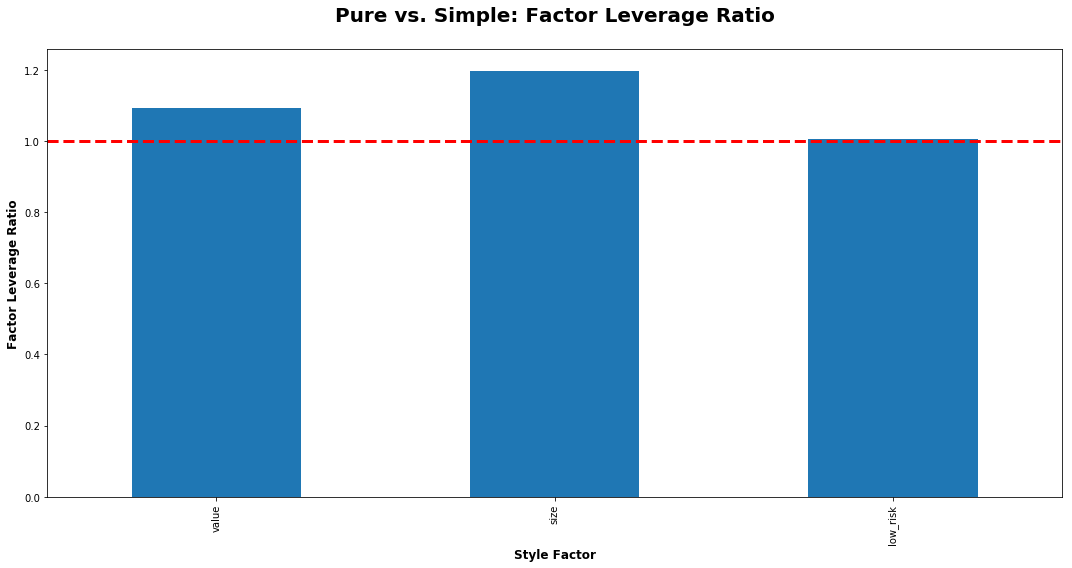

In [152]:
plt.figure(figsize=(15, 8))
factor_lev_ratio.plot.bar()
plt.title('Pure vs. Simple: Factor Leverage Ratio\n', fontweight='bold', fontsize=20)
plt.ylabel('Factor Leverage Ratio', fontweight='bold', fontsize=12)
plt.xlabel('Style Factor', fontweight='bold', fontsize=12)
plt.axhline(1, color='r', linestyle='--', linewidth=3)
plt.tight_layout();

All are less than 1.3, indicating mild collinearity.

---

# Summary of results

**Check for unit weight to world and dollar neutral to sector and styles:**

In [30]:
pd.DataFrame(round(omega_p.sum(axis=1), 2), columns=['Wgt'])

,Wgt
world_factor,1.0
Sector_Consumer Discretionary,0.0
Sector_Consumer Staples,0.0
Sector_Energy,0.0
Sector_Financials,-0.0
Sector_Health Care,0.0
Sector_Industrials,-0.0
Sector_Information Technology,0.0
Sector_Materials,0.0
Sector_Real Estate,-0.0


**Check cap-weighted sector returns equal zero:**

In [34]:
pd.DataFrame(round(np.dot(f_pure.T, SW_g.values)[0][0], 10), index=['Cap-Weighted Sectors'], columns=['Return'])

,Return
Cap-Weighted Sectors,0.0


**Check exposures are calibrated correctly:**

In [27]:
round(pd.DataFrame(np.dot(omega_p, X), index=X.columns, columns=X.columns), 2)

,world_factor,Sector_Consumer Discretionary,Sector_Consumer Staples,Sector_Energy,Sector_Financials,Sector_Health Care,Sector_Industrials,Sector_Information Technology,Sector_Materials,Sector_Real Estate,Sector_Telecommunication Services,Sector_Utilities,value,size,low_risk
world_factor,1.0,0.13,0.07,0.06,0.14,0.13,0.09,0.29,0.02,0.03,0.02,0.02,-0.0,-0.0,0.0
Sector_Consumer Discretionary,0.0,0.87,-0.07,-0.06,-0.14,-0.13,-0.09,-0.29,-0.02,-0.03,-0.02,-0.02,-0.0,-0.0,0.0
Sector_Consumer Staples,0.0,-0.13,0.93,-0.06,-0.14,-0.13,-0.09,-0.29,-0.02,-0.03,-0.02,-0.02,0.0,-0.0,-0.0
Sector_Energy,0.0,-0.13,-0.07,0.94,-0.14,-0.13,-0.09,-0.29,-0.02,-0.03,-0.02,-0.02,0.0,-0.0,-0.0
Sector_Financials,-0.0,-0.13,-0.07,-0.06,0.86,-0.13,-0.09,-0.29,-0.02,-0.03,-0.02,-0.02,0.0,-0.0,0.0
Sector_Health Care,-0.0,-0.13,-0.07,-0.06,-0.14,0.87,-0.09,-0.29,-0.02,-0.03,-0.02,-0.02,-0.0,-0.0,0.0
Sector_Industrials,0.0,-0.13,-0.07,-0.06,-0.14,-0.13,0.91,-0.29,-0.02,-0.03,-0.02,-0.02,-0.0,-0.0,0.0
Sector_Information Technology,0.0,-0.13,-0.07,-0.06,-0.14,-0.13,-0.09,0.71,-0.02,-0.03,-0.02,-0.02,-0.0,-0.0,0.0
Sector_Materials,0.0,-0.13,-0.07,-0.06,-0.14,-0.13,-0.09,-0.29,0.98,-0.03,-0.02,-0.02,-0.0,-0.0,-0.0
Sector_Real Estate,-0.0,-0.13,-0.07,-0.06,-0.14,-0.13,-0.09,-0.29,-0.02,0.97,-0.02,-0.02,0.0,0.0,-0.0


**Check sector weight of each factor, including the cap-weighted world portfolio**:

In [81]:
sector_wgts = pd.concat([pd.DataFrame(w_n.values, index=df.index, columns=['world_portfolio']), df['GICS Sector']], axis=1)
sector_wgts = sector_wgts.groupby('GICS Sector').sum()

factor_names = omega_p.index
for factor in factor_names:
    temp_df = pd.DataFrame(omega_p.loc[factor].values, index=df.index, columns=[factor])
    temp_df = pd.concat([temp_df, df['GICS Sector']], axis=1)
    temp_df = temp_df.groupby('GICS Sector').sum()
    sector_wgts[factor] = temp_df

In [83]:
round(sector_wgts, 4)

,world_portfolio,world_factor,Sector_Consumer Discretionary,Sector_Consumer Staples,Sector_Energy,Sector_Financials,Sector_Health Care,Sector_Industrials,Sector_Information Technology,Sector_Materials,Sector_Real Estate,Sector_Telecommunication Services,Sector_Utilities,value,size,low_risk
GICS Sector,,,,,,,,,,,,,,,,
Consumer Discretionary,0.1258,0.1258,0.8742,-0.1258,-0.1258,-0.1258,-0.1258,-0.1258,-0.1258,-0.1258,-0.1258,-0.1258,-0.1258,-0.0,0.0,-0.0
Consumer Staples,0.0732,0.0732,-0.0732,0.9268,-0.0732,-0.0732,-0.0732,-0.0732,-0.0732,-0.0732,-0.0732,-0.0732,-0.0732,0.0,0.0,0.0
Energy,0.0574,0.0574,-0.0574,-0.0574,0.9426,-0.0574,-0.0574,-0.0574,-0.0574,-0.0574,-0.0574,-0.0574,-0.0574,0.0,0.0,-0.0
Financials,0.1387,0.1387,-0.1387,-0.1387,-0.1387,0.8613,-0.1387,-0.1387,-0.1387,-0.1387,-0.1387,-0.1387,-0.1387,0.0,0.0,0.0
Health Care,0.1272,0.1272,-0.1272,-0.1272,-0.1272,-0.1272,0.8728,-0.1272,-0.1272,-0.1272,-0.1272,-0.1272,-0.1272,0.0,-0.0,0.0
Industrials,0.0922,0.0922,-0.0922,-0.0922,-0.0922,-0.0922,-0.0922,0.9078,-0.0922,-0.0922,-0.0922,-0.0922,-0.0922,0.0,0.0,-0.0
Information Technology,0.2939,0.2939,-0.2939,-0.2939,-0.2939,-0.2939,-0.2939,-0.2939,0.7061,-0.2939,-0.2939,-0.2939,-0.2939,-0.0,0.0,-0.0
Materials,0.0248,0.0248,-0.0248,-0.0248,-0.0248,-0.0248,-0.0248,-0.0248,-0.0248,0.9752,-0.0248,-0.0248,-0.0248,0.0,0.0,-0.0
Real Estate,0.0257,0.0257,-0.0257,-0.0257,-0.0257,-0.0257,-0.0257,-0.0257,-0.0257,-0.0257,0.9743,-0.0257,-0.0257,0.0,0.0,0.0
